In [1]:
#Import packages needed for training
import snowflake.connector
import pickle
import boto3
import pandas as pd
from random import sample 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

#Packages needed for testing
#Pickle file for TFIDF
#Pickle file for Logistic Regression model results


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1604692191294_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#PYTHON connection info
conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user='APP_SPARK_PROD',
    password='>6txhcQ*7&^Qrq`j'
    )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Careful not to get CNR for NR
#CNR, NR, PM - contains(r.observations, ',NR,')
#NR, PM - substring(r.observations, 1, 2) = 'NR'
#CNR, PM - DONT WANT

query_1 = "select distinct r.ugc_id,  r.review_headline, r.review_comments, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2018-10-01' "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews_1 = pd.read_sql(query_1, conn)
reviews_1.head(100)
#reviews.info()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID  ... NR
0   124220429  ...  1
1    96754263  ...  1
2   135992833  ...  1
3   136065398  ...  1
4   136059207  ...  1
..        ...  ... ..
95  220110436  ...  1
96  220089793  ...  1
97  220100371  ...  1
98  220125711  ...  1
99  220118330  ...  1

[100 rows x 4 columns]

In [5]:
reviews_1.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530937 entries, 0 to 530936
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   UGC_ID           530937 non-null  int64 
 1   REVIEW_HEADLINE  530470 non-null  object
 2   REVIEW_COMMENTS  529948 non-null  object
 3   NR               530937 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 16.2+ MB

In [6]:
#Get all other observations that DONT have NR label
query_2 = "select distinct r.ugc_id, r.review_headline, r.review_comments, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and not contains(r.observations, ',NR,') and substring(r.observations, 1, 2) != 'NR' \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2018-10-01' "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
reviews_2 = pd.read_sql(query_2, conn)
reviews_2.head(100)
reviews_2.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69485629 entries, 0 to 69485628
Data columns (total 4 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   UGC_ID           int64 
 1   REVIEW_HEADLINE  object
 2   REVIEW_COMMENTS  object
 3   NR               int64 
dtypes: int64(2), object(2)
memory usage: 2.1+ GB

In [8]:
#Take a random sample of NOT NR labels equal to however many NR labels there are
reviews_2 = reviews_2.sample(n=521358, random_state=1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
reviews = pd.concat([reviews_1, reviews_2], axis=0)
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

             UGC_ID  ... NR
0         124220429  ...  1
1          96754263  ...  1
2         135992833  ...  1
3         136065398  ...  1
4         136059207  ...  1
...             ...  ... ..
20190402  266370069  ...  0
3748866   213757287  ...  0
1518819   264946998  ...  0
36252653  258787901  ...  0
42838057  233341223  ...  0

[1052295 rows x 4 columns]

In [10]:
reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS']
#Use set_option so text doesn't truncate

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
reviews.head(100)

#reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID                            REVIEW_HEADLINE  \
0   124220429  Totally disappointed                        
1   96754263   I will definitely buy                       
2   135992833  Hehd                                        
3   136065398  Did not receive my product                  
4   136059207  Item available                              
..        ...             ...                              
95  220110436  never received item                         
96  220089793  Not a very dependable company               
97  220100371  Disappointed at the transportation          
98  220125711  Horrible e-commerce and store service       
99  220118330  After 18 years of service you let me down   

                                                                                                                                                                                                                                                                                       

In [11]:
X = reviews[['ALL_TEXT']]
#X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
y = reviews[['NR']]
#y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
#Split into training and test data sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=9, stratify = y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [140]:
#Use this when working directly in notebook, otherwise need pickle file

#Fit TFIDF vectorizer and transform directly
#vectorizer = TfidfVectorizer(analyzer = 'word', max_features = 30000, stop_words= 'english', lowercase=True)
#xtrain_final = vectorizer.fit_transform(xtrain['ALL_TEXT'].apply(lambda x: np.str_(x)))
#xtest_final = vectorizer.transform(xtest['ALL_TEXT'].apply(lambda x: np.str_(x)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [97]:
#Prepare tfidf for pickling
vectorizer = TfidfVectorizer(analyzer = 'word', max_features = 30000, stop_words= 'english', lowercase=True)
tfidf_model = vectorizer.fit(xtrain['ALL_TEXT'].apply(lambda x: np.str_(x)))

#Create pickle file
pickle.dump(tfidf_model, open("/mnt/tmp/tfidf.pkl", "wb") )

#Load pickle directly from temp path
#tfidf = pickle.load(open("/mnt/tmp/tfidf.pkl", 'rb'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [98]:
#Write pickle file to S3 bucket
s3 = boto3.resource('s3')
s3.Object('pwr-analytics-emr','tfidf.pkl').upload_file(Filename='/mnt/tmp/tfidf.pkl')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [99]:
#Open pickle file from S3 bucket back into this notebook
obj = s3.Object('pwr-analytics-emr','tfidf.pkl')
body = obj.get()['Body'].read()
tfidf = pickle.loads(body)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [100]:
#Use vocab from pickle file to fit/transform training set
tfidf_new = TfidfVectorizer(analyzer = 'word', max_features = 30000, stop_words= 'english', lowercase=True, vocabulary = tfidf.vocabulary_)
xtrain_final = tfidf_new.fit_transform(xtrain['ALL_TEXT'].apply(lambda x: np.str_(x)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [141]:
#Specify Logistic regression model
clf = LogisticRegression(max_iter=1000, solver = 'lbfgs')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [156]:
#Train model
#Directly
#clf.fit(xtrain_final, np.ravel(ytrain))
#Save as lr_model to be pickled
lr_model=clf.fit(xtrain_final, np.ravel(ytrain))



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [157]:
#Pickle file for LR model
pickle.dump(lr_model, open("/mnt/tmp/lr.pkl", "wb") )
s3.Object('pwr-analytics-emr','lr.pkl').upload_file(Filename='/mnt/tmp/lr.pkl')
obj = s3.Object('pwr-analytics-emr','lr.pkl')
body = obj.get()['Body'].read()
lr = pickle.loads(body)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [178]:
#Fit text columns with TFIDF pickle file in order to have numeric vectors
xtest_final = tfidf_new.transform(xtest['ALL_TEXT'].apply(lambda x: np.str_(x)))

#Use LR model with input TFIDF vectors to predict

#Predict 0/1
#Directly
#y_pred = clf.predict(xtest_final)
#With pickle
y_pred = lr.predict(xtest_final)

#Predict probability
#Directly
#probs = clf.predict_proba(xtest_final)
#With pickle
probs = lr.predict_proba(xtest_final)
y_probs = probs[:,1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [180]:
print(y_pred)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[1 1 0 ... 1 0 1]

In [181]:
print(y_probs)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.7671565  0.90024161 0.18519248 ... 0.62674937 0.10957455 0.9982648 ]

In [182]:
#EVERYTHING BELOW IS FOR VERIFYING MODEL RESULTS

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [183]:
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix, \
                            roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [184]:
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [185]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [186]:
%matplotlib inline

In [187]:
#Confusion matrix
#confusion_matrix(ytest, y_pred)
#tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
#print("TN: {}".format(tn), "FP: {}".format(fp), "FN: {}".format(fn), "TP: {}".format(tp))
plot_confusion_matrix(clf, xtest_final, ytest)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

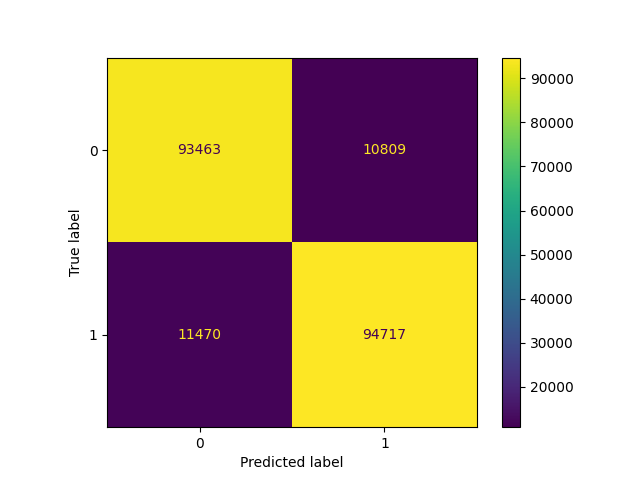

In [188]:
%matplot plt

In [189]:
#Evaluating model performance
#There are inherently mostly NOLABEL so accuracy could be high just bc of those
#Want to make sure that when there is a label besides NOLABEL that it is being accurately predicted


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [190]:
#Model performance metrics
#Assess at individual label level as well as overall

#Accuracy is overall correct predictions - not great measurement tool for imbalanced data
#Precision - TP / TP + FP = spam detection - don't want to mark something as spam (FP) when it isn't
#Recall - TP / TP + FN = sickness - don't want to tell someone they aren't sick (FN) when they are and can spread it
#F1 - balance of precision and recall

#We want to make sure if bomb emoji then it gets marked - even at the expense of marking other things potentially offensive that aren't 
#Important not to have FN - USE RECALL
#Also don't want to be marking a bunch of stuff as offensive when it isn't and making moderation do everything anyway
#Important not to have too many FP - USE PRECISION
#Use F1 for balance between both
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.8941409015532716
Precision is:  0.8975702670431931
Recall is:  0.891983011103054
F1 Score is:  0.894767916944165

In [191]:
print(classification_report(ytest,y_pred))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              precision    recall  f1-score   support

           0       0.89      0.90      0.89    104272
           1       0.90      0.89      0.89    106187

    accuracy                           0.89    210459
   macro avg       0.89      0.89      0.89    210459
weighted avg       0.89      0.89      0.89    210459

In [171]:
probs = clf.predict_proba(xtest_final)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)
#print(roc_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [172]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [173]:
#ROC CURVE
#Assumes we care about 0 and 1 classification the same - we don't
#We care more about performance of 1 classification - use precision recall curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

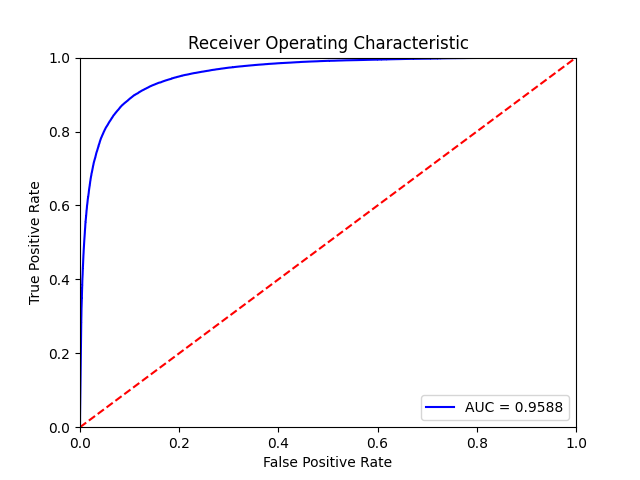

In [174]:
%matplot plt

In [175]:
#Find best threshold (ROC Curve)
#Ideally want tpr = 1 and fpr = 0, so want tpr - fpr as close to 1 as possible
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
opt_tpr = tpr[optimal_idx]
opt_fpr = fpr[optimal_idx]
print("Optimal threshold value:", optimal_threshold)
print("Optimal tpr value:", opt_tpr)
print("Optimal fpr value:", opt_fpr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Optimal threshold value: 0.486930133572288
Optimal tpr value: 0.8961831485963442
Optimal fpr value: 0.10717162804971612

In [176]:
t = optimal_threshold
y_pred_new = (preds >= t).astype(int)
#y_pred_new

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [177]:
#Scores with best threshold cutoff
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred_new)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred_new)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred_new)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred_new)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.8945210230971353
Precision is:  0.89491056818823
Recall is:  0.8961831485963442
F1 Score is:  0.8955464063051406

In [38]:
len(y_pred_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

210459

In [39]:
#PRECISION RECALL CURVE
#Better for what we want to assess which is how well label is assigned (i.e. when it gets a 1 instead of a 0)

precision, recall, pr_threshold = precision_recall_curve(ytest, preds)
pr_auc = metrics.auc(recall, precision)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
plt.title('Precision - Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % pr_auc)
plt.legend(loc = 'lower right')
no_skill = len(ytest[ytest['NR']==1]) / len(ytest)
plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

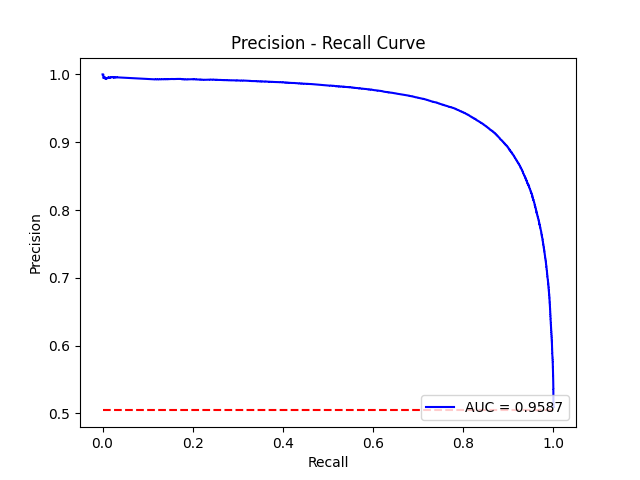

In [42]:
%matplot plt

In [43]:
#Best F1 score optimizes precision recall trade off

fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (pr_threshold[ix], fscore[ix]))

print('Recall=%f' % recall[ix])
print('Precision=%f' % precision[ix])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'argmax' is not defined
Traceback (most recent call last):
NameError: name 'argmax' is not defined



In [44]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
plt.hist(preds, bins=10)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

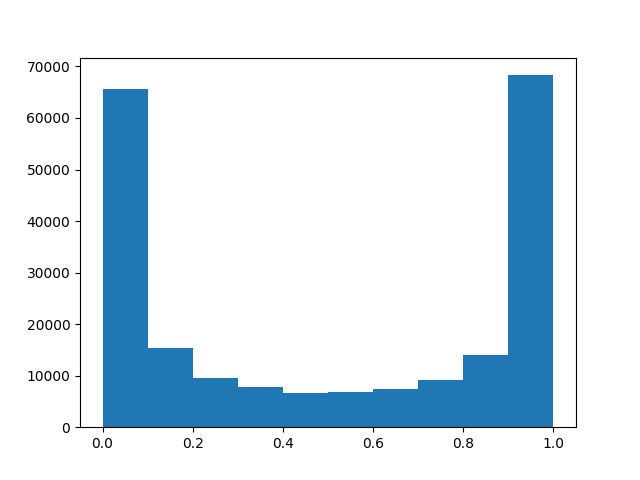

In [46]:
%matplot plt

In [47]:
preds_df = pd.DataFrame(data=preds, columns = ['pred_prob'])
#preds_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
ytest.reset_index(drop=True, inplace=True)
preds_df.reset_index(drop=True, inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
hist_plot_data = pd.concat([ytest, preds_df], axis = 1)
#hist_plot_data

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [352]:
NR_0 = hist_plot_data.loc[hist_plot_data.NR == 0, 'pred_prob']
NR_1 = hist_plot_data.loc[hist_plot_data.NR == 1, 'pred_prob']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [356]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [357]:
kwargs = dict(alpha=0.5, bins=20)

plt.hist(NR_0, **kwargs, color='b', label='NR=0')
plt.hist(NR_1, **kwargs, color='g', label='NR=1')
plt.gca().set(title='Histogram of NR Label Probs', ylabel='Frequency', xlabel = 'Predicted Probability')
plt.legend();

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

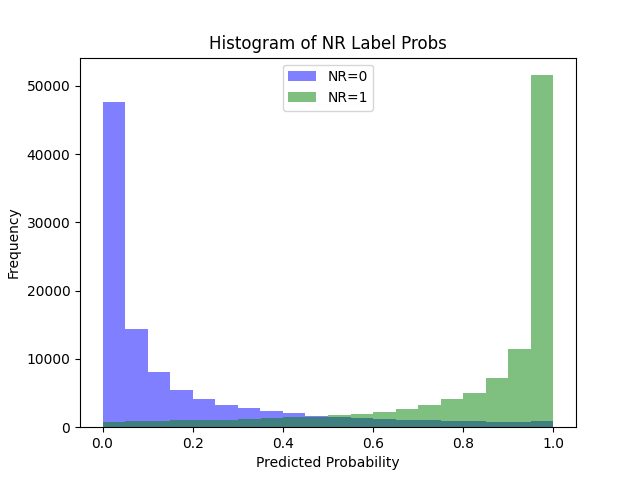

In [358]:
%matplot plt

In [316]:
#Amount of data that is actually 0 but predicted as 1 with probability > 80%
hist_plot_data.loc[(hist_plot_data.NR == 0) & (hist_plot_data.pred_prob > 0.8)].count()
#3233 / 204885 = ~1%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           3233
pred_prob    3233
dtype: int64

In [317]:
#Amount of data that is actually 1 but predicted as 0 with probability < 20%
hist_plot_data.loc[(hist_plot_data.NR == 1) & (hist_plot_data.pred_prob < 0.2)].count()
#3683 / 204885 = ~1%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           3683
pred_prob    3683
dtype: int64

In [318]:
#Amount of data (0 or 1) that is between probabilities 20% - 80%
hist_plot_data.loc[(hist_plot_data.pred_prob <0.8) & (hist_plot_data.pred_prob > 0.2)].count()
#47346 / 204885 = ~23%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           47346
pred_prob    47346
dtype: int64

In [161]:
#importance = clf.coef_
#importance

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [162]:

#feature_names = vectorizer.get_feature_names()
#dense = importance
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [287]:
xtest.reset_index(drop=True, inplace=True)
hist_plot_data.reset_index(drop=True, inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [303]:
results = pd.concat([xtest, hist_plot_data], axis=1)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
0       headline Daughter loves it!! comment This is so cute, my daughter loves all the robots from Star Wars, and here they are all on one shirt!!                                                                                                                                                                                                                                                                                   
1       headline Love these too!!! comment The warmest earmuffs I have ever used in my life and they don't even make my ears sweat!! These are the best ea

In [304]:
results['ALL_TEXT'] = results['ALL_TEXT'].astype(str)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
0       headline Daughter loves it!! comment This is so cute, my daughter loves all the robots from Star Wars, and here they are all on one shirt!!                                                                                                                                                                                                                                                                                   
1       headline Love these too!!! comment The warmest earmuffs I have ever used in my life and they don't even make my ears sweat!! These are the best ea

In [305]:
results_sparkdf = spark.createDataFrame(results)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [306]:
sfOptions2 = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_WORKSHOP',
  'sfSchema' : 'DATA_SCIENCE',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [307]:
 results_sparkdf.write.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions2) \
    .option("dbtable","MODLABEL_TEST_2").mode("append").save()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…